In [1]:
import typing
import numpy as np
import pandas as pd
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.eager import context
from scipy.optimize import curve_fit

tf.config.threading.set_inter_op_parallelism_threads(5)
_ = tf.Variable([1])

import DeepLearningInterpretable as DLI

In [2]:
def curve_fittingPL(v,a,b):
    return a*np.power(v,-b)

def curve_fittingExpo(v,a,b):
    return a*np.power(v,-b)

def plot_kernels(kernels, ax):
    for kernel in kernels: 
        ax.plot(kernels[kernel][1:], label = 'kernel approx with kernel:'+str(kernel))
        ax.set_title('regressed kernel ')
        ax.set_xlabel('t')
        ax.set_ylabel('Price ($)')
        ax.set_xlim((1,500))
        ax.legend()
        
def plot_loss(ax, history):
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper right')


In [3]:
def fNN(row):
    if row['sign'] > 0:
        return row['ask_size']
    else:
        return row['bid_size']
def fWN(row):
    if row['sign'] > 0:
        return row['ask_size_normalized']
    else:
        return row['bid_size_normalized']

$\underline{\text{Data loading:}}$

In [4]:
# load clean data
%store -r dfSPMINI
%store -r dfUST
#dfSPMINI = pd.read_csv('dfSPMINI.csv')
#dfSPMINI = pd.read_csv('dfUST.csv')

dfSPMINI['sign'] = dfSPMINI['qty_signed'].apply(lambda x: np.sign(x))
dfUST['sign'] = dfUST['qty_signed'].apply(lambda x: np.sign(x))

#dfSPMINI['best_opposed_quantity_NN'] = dfSPMINI.apply(fNN, axis = 1) # we select the best opposed qtys without normalization
#dfUST['best_opposed_quantity_NN'] = dfUST.apply(fNN, axis = 1) # we select the best opposed qtys without normalization

dfSPMINI['best_opposed_quantity_WN'] = dfSPMINI.apply(fWN, axis = 1) # we select the best opposed qtys with normalization
dfUST['best_opposed_quantity_WN'] = dfUST.apply(fWN, axis = 1) # we select the best opposed qtys with normalization

#dfSPMINI['quotient_trades_best_opposed_NN'] = dfSPMINI['qty'].div(dfSPMINI['best_opposed_quantity_NN']) # quotient with non-normalized data
#dfUST['quotient_trades_best_opposed_NN'] = dfUST['qty'].div(dfUST['best_opposed_quantity_NN']) # quotient with non-normalized data

#dfSPMINI['quotient_trades_best_opposed_MN'] = dfSPMINI['qty']/(dfSPMINI['best_opposed_quantity_WN'].mean()) # quotient with non-normalized data and we use the mean as denominator
#dfUST['quotient_trades_best_opposed_MN'] = dfUST['qty']/(dfUST['best_opposed_quantity_WN'].mean()) # quotient with non-normalized data and we use the mean as denominator

dfSPMINI['quotient_trades_best_opposed_WN'] = dfSPMINI['qty_signed_normalized'].abs().div(dfSPMINI['best_opposed_quantity_WN'].mean()) # quotient with normalized data
dfUST['quotient_trades_best_opposed_WN'] = dfUST['qty_signed_normalized'].abs().div(dfUST['best_opposed_quantity_WN'].mean()) # quotient with normalized data

In [5]:
dfSPMINI.head()

qty     ask      bid  evt_seq_num                    ts_recv  \
0  258  2508.0  2508.00            1 2019-01-01 23:00:00.012665   
1    1  2509.0  2508.25            2 2019-01-01 23:00:00.014957   
2    1  2509.0  2508.25            3 2019-01-01 23:00:00.015000   
3    2  2509.0  2508.25            4 2019-01-01 23:00:00.015022   
4    3  2509.0  2508.25            5 2019-01-01 23:00:00.015042   

                   ts_market type  bid_size  ask_size       mid  ...  \
0 2019-01-01 23:00:00.000000            257       258  2508.000  ...   
1 2019-01-01 23:00:00.007649              6         2  2508.625  ...   
2 2019-01-01 23:00:00.008848              6         2  2508.625  ...   
3 2019-01-01 23:00:00.008000              6         2  2508.625  ...   
4 2019-01-01 23:00:00.008000              6         2  2508.625  ...   

   returns_squared_x  returns_squared_y  qty_signed_normalized  \
0           0.390625           0.012808               0.000000   
1           0.000000           0.012808              -0.147781   
2           0.000000           0.012808              -0.147781   
3           0.000000           0.012808              -0.295561   
4           0.000000           0.012808               0.443342   

   bid_size_normalized  ask_size_normalized  returns_normalized  order_type  \
0            37.979617            38.127398            5.522559           0   
1             0.886684             0.295561            0.000000           0   
2             0.886684             0.295561            0.000000           0   
3             0.886684             0.295561            0.000000           0   
4             0.886684             0.295561            0.000000           1   

   sign  best_opposed_quantity_WN  quotient_trades_best_opposed_WN  
0   0.0                 37.979617                         0.000000  
1  -1.0                  0.886684                         0.050776  
2  -1.0                  0.886684                         0.050776  
3  -1.0                  0.886684                         0.101552  
4   1.0                  0.295561                         0.152328  

[5 rows x 25 columns]

In [6]:
# we store the desired data

#SPMINI
mid_SPMINI = dfSPMINI['mid'].copy()

returns_SPMINI = dfSPMINI['returns'].copy()
returns_normalized_SPMINI = dfSPMINI['returns_normalized'].copy()

qty_signed_normalized_SPMINI = dfSPMINI['qty_signed_normalized'].copy()
epsilons_SPMINI = qty_signed_normalized_SPMINI.apply(lambda x: np.sign(x)).copy()
qty_signed_SPMINI = dfSPMINI['qty'].multiply(epsilons_SPMINI)

#UST
mid_UST = dfUST['mid'].copy()

returns_UST = dfUST['returns'].copy()
returns_normalized_UST = dfUST['returns_normalized'].copy()

qty_signed_normalized_UST = dfUST['qty_signed_normalized'].copy()
epsilons_UST = qty_signed_normalized_UST.apply(lambda x: np.sign(x)).copy()
qty_signed_UST = dfUST['qty'].multiply(epsilons_UST)

# lengths
N_SPMINI = len(mid_SPMINI)
N_UST = len(mid_UST)

$\underline{\text{Stylized facts:}}$

In [7]:
max_lag = 1000

$\underline{\text{Autocorrelation of market data:}}$

In [8]:
# trades autcovariance 
acf_epsilonsSPMINI = inter.autocovariance(epsilons_SPMINI.values , max_lag)
acf_epsilonsUST = inter.autocovariance(epsilons_UST.values , max_lag)

% store acf_epsilonsSPMINI
% store acf_epsilonsUST

# curve fitting 
params1, cov = curve_fit(curve_fittingPL, np.arange(1,max_lag+1), acf_epsilonsSPMINI[1:] )
appro1 = curve_fittingPL(np.arange(1,N_SPMINI+1), *params1)

params2, cov = curve_fit(curve_fittingPL, np.arange(1,max_lag+1), acf_epsilonsUST[1:] )
appro2 = curve_fittingPL(np.arange(1,N_UST+1), *params2)


Stored 'acf_epsilonsSPMINI' (Series)
Stored 'acf_epsilonsUST' (Series)


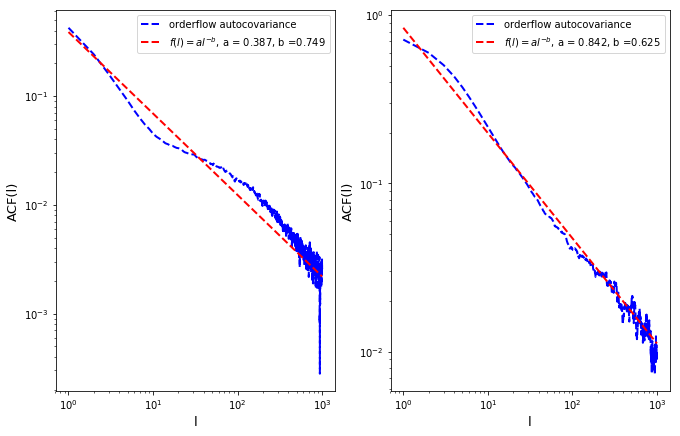

In [9]:
# plot
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(np.arange(1,max_lag+1), acf_epsilonsSPMINI[1:], '--b', linewidth=2, label ='orderflow autocovariance')
ax1[0].plot(np.arange(1,max_lag+1), appro1[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params1[0])[:5] + ', b =' + str(params1[1])[:5] )
ax1[0].set_xlabel('l', fontsize=13)
ax1[0].set_ylabel('ACF(l)', fontsize=13)
ax1[0].legend()
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')


ax1[1].plot(np.arange(1,max_lag+1), acf_epsilonsUST[1:], '--b', linewidth=2, label ='orderflow autocovariance')
ax1[1].plot(np.arange(1,max_lag+1), appro2[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = al^{-b}$' + ', a = ' + str(params2[0])[:5] + ', b =' + str(params2[1])[:5] )
ax1[1].set_xlabel('l', fontsize=13)
ax1[1].set_ylabel('ACF(l)', fontsize=13)
ax1[1].legend()
ax1[1].set_xscale('log')
ax1[1].set_yscale('log')

plt.show()

In [10]:
# trades autcovariance 
acf_returnsSPMINI = inter.autocovariance(returns_SPMINI.values , max_lag)
acf_returnsUST = inter.autocovariance(returns_UST.values , max_lag)

% store acf_returnsSPMINI
% store acf_returnsUST

# curve fitting 
params1, cov = curve_fit(curve_fittingExpo, np.arange(1,max_lag+1), acf_returnsSPMINI[1:] )
appro1 = curve_fittingExpo(np.arange(1,N_SPMINI+1), *params1)

params2, cov = curve_fit(curve_fittingExpo, np.arange(1,max_lag+1), acf_returnsUST[1:] )
appro2 = curve_fittingExpo(np.arange(1,N_UST+1), *params2)


Stored 'acf_returnsSPMINI' (Series)
Stored 'acf_returnsUST' (Series)


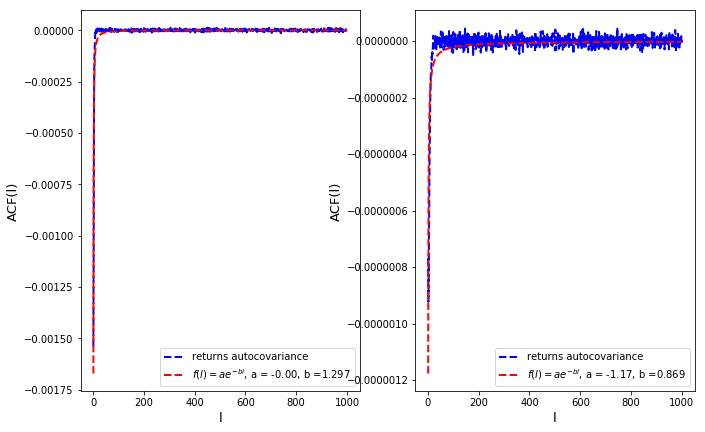

In [11]:
# plot
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(np.arange(1,max_lag+1), acf_returnsSPMINI[1:], '--b', linewidth=2, label ='returns autocovariance')
ax1[0].plot(np.arange(1,max_lag+1), appro1[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = ae^{-bl}$' + ', a = ' + str(params1[0])[:5] + ', b =' + str(params1[1])[:5] )
ax1[0].set_xlabel('l', fontsize=13)
ax1[0].set_ylabel('ACF(l)', fontsize=13)
ax1[0].legend()



ax1[1].plot(np.arange(1,max_lag+1), acf_returnsUST[1:], '--b', linewidth=2, label ='returns autocovariance')
ax1[1].plot(np.arange(1,max_lag+1), appro2[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = ae^{-bl}$' + ', a = ' + str(params2[0])[:5] + ', b =' + str(params2[1])[:5] )
ax1[1].set_xlabel('l', fontsize=13)
ax1[1].set_ylabel('ACF(l)', fontsize=13)
ax1[1].legend()

plt.show()

$\underline{\text{Market Response:}}$

$\underline{\text{Unconditionnal Impact:}}$


Stored 'ResSPMINI' (Series)
Stored 'ResUST' (Series)


Text(0,0.5,'R(l)')

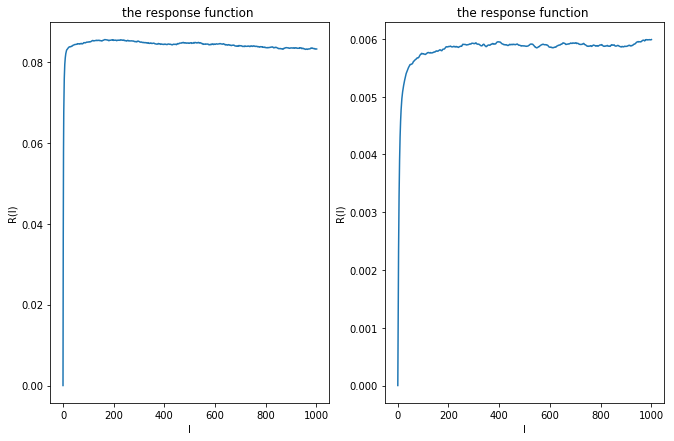

In [12]:
# response function 

ResSPMINI = inter.response_function(epsilons_SPMINI.values, mid_SPMINI.values, max_lag+1)
ResUST = inter.response_function(epsilons_UST.values, mid_UST.values, max_lag+1)

% store ResSPMINI
% store ResUST
# plot
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(ResSPMINI)
ax1[0].set_title('the response function ')
ax1[0].set_xlabel('l')
ax1[0].set_ylabel('R(l)')

ax1[1].plot(ResUST)
ax1[1].set_title('the response function ')
ax1[1].set_xlabel('l')
ax1[1].set_ylabel('R(l)')

$\underline{\text{Conditionnal impact:}}$

In [13]:
#dfSPMINI['quotient_trades_best_opposed_MN'] = dfSPMINI['qty']/(dfSPMINI['best_opposed_quantity_NN'].mean())
#dfUST['quotient_trades_best_opposed_MN'] = dfUST['qty']/(dfUST['best_opposed_quantity_NN'].mean())

#dfSPMINI['lag_one_response'] = dfSPMINI.sign.multiply(dfSPMINI.returns)
#dfUST['lag_one_response'] = dfUST.sign.multiply(dfUST.returns)

#conditionnal_reponse_SPMINI = dfSPMINI.groupby(['quotient_trades_best_opposed_WN']).agg({'lag_one_response': 'mean'}).copy()
#conditionnal_reponse_UST = dfUST.groupby(['quotient_trades_best_opposed_WN']).agg({'lag_one_response': 'mean'}).copy()


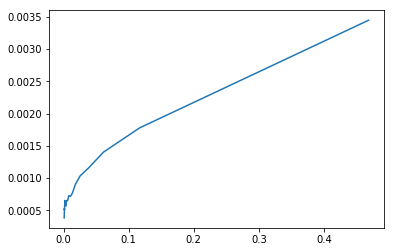

In [36]:
x_UST = dfUST['quotient_trades_best_opposed_WN']
y_UST = dfUST['sign'].multiply(dfUST['returns'])
res_UST = inter.histeq(x_UST, y_UST, num_bins =  20, use_quantiles = True)
plt.plot(res_UST.mean_x, res_UST.mean_y) # se lit comme qt trqde -> proba de changement de prix 

In [34]:
x_SPMINI = dfSPMINI['quotient_trades_best_opposed_WN']
y_SPMINI = dfSPMINI['sign'].multiply(dfSPMINI['returns'])
res_SPMINI = inter.histeq(x_SPMINI, y_SPMINI, num_bins =  20, use_quantiles = True)
plt.plot(res_SPMINI.mean_x, res_SPMINI.mean_y) # se lit comme qt trqde -> proba de changement de prix 

In [35]:
dfSPMINI.returns.replace({0.0: np.nan}).std()

0.24192437806244246

$\underline{\text{The variogram:}}$


Stored 'VarioSPMINI' (Series)
Stored 'VarioUST' (Series)


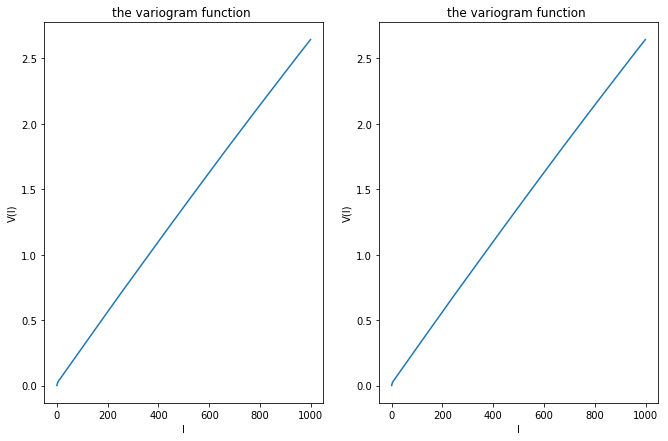

In [16]:
# the variogram
VarioSPMINI = inter.variogram(mid_SPMINI.values, max_lag)
VarioUST = inter.variogram(mid_UST.values, max_lag)

% store VarioSPMINI
% store VarioUST

# plot 
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(VarioSPMINI)
ax1[0].set_title('the variogram function ')
ax1[0].set_xlabel('l')
ax1[0].set_ylabel('V(l)')

ax1[1].plot(VarioSPMINI)
ax1[1].set_title('the variogram function ')
ax1[1].set_xlabel('l')
ax1[1].set_ylabel('V(l)')

plt.show()

In [17]:
# signature plot 

signature_plot_SPMINI = VarioSPMINI[1:]/np.arange(1,len(VarioSPMINI))
signature_plot_UST = VarioUST[1:]/np.arange(1,len(VarioUST))

# plot 
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(signature_plot_SPMINI[1:])
ax1[0].set_title('the signature plot ')
ax1[0].set_xlabel('l')
ax1[0].set_ylabel('D(l)')

ax1[1].plot(signature_plot_UST[1:])
ax1[1].set_title('the signature plot ')
ax1[1].set_xlabel('l')
ax1[1].set_ylabel('D(l)')

plt.show()

$\underline{\text{Importance of volume and the imbalance:}}$

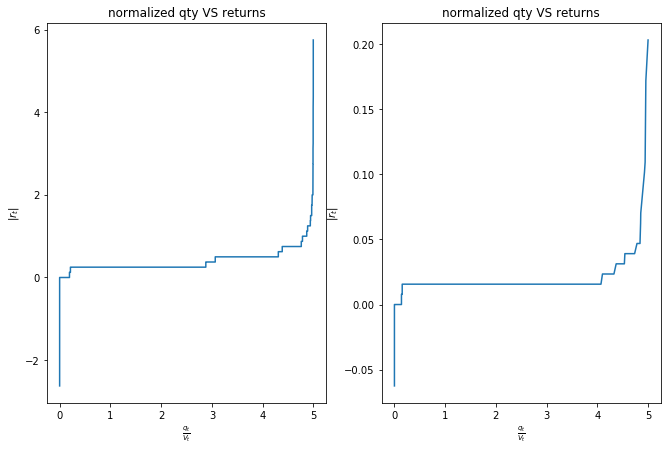

In [23]:
# we look to the jump due to the imbalance 

# plot 
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(dfSPMINI['quotient_trades_best_opposed_WN'][dfSPMINI['quotient_trades_best_opposed_WN'] < 5].sort_values(ascending  
                              = True), 
            dfSPMINI.sign[dfSPMINI['quotient_trades_best_opposed_WN'] < 5].multiply(returns_SPMINI[dfSPMINI['quotient_trades_best_opposed_WN'] < 5]).sort_values(ascending  
                              = True) )
ax1[0].set_title('normalized qty VS returns')
ax1[0].set_xlabel(r'$\frac{q_{t}}{V_{t}}$')
ax1[0].set_ylabel(r'$|r_{t}|$')


ax1[1].plot(dfUST['quotient_trades_best_opposed_WN'][dfUST['quotient_trades_best_opposed_WN'] < 5].sort_values(ascending  
                              = True), 
            dfUST.sign[dfUST['quotient_trades_best_opposed_WN'] < 5].multiply(returns_UST[dfUST['quotient_trades_best_opposed_WN'] < 5]).sort_values(ascending  
                              = True) )
ax1[1].set_title('normalized qty VS returns')
ax1[1].set_xlabel(r'$\frac{q_{t}}{V_{t}}$')
ax1[1].set_ylabel(r'$|r_{t}|$')

plt.show()

In [29]:
def hist(data, bins, title, labels, range = None):
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes()
    plt.ylabel("Proportion")
    values, base, _ = plt.hist( data  , bins = bins, normed=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
    ax_bis = ax.twinx()
    values = np.append(values,0)
    ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
    plt.xlabel(labels)
    plt.ylabel("Proportion")
    plt.title(title)
    ax_bis.legend();
    ax.legend();
    plt.show()
    return

/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


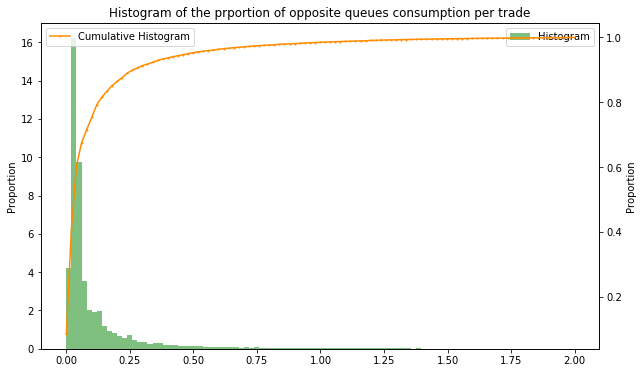

/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


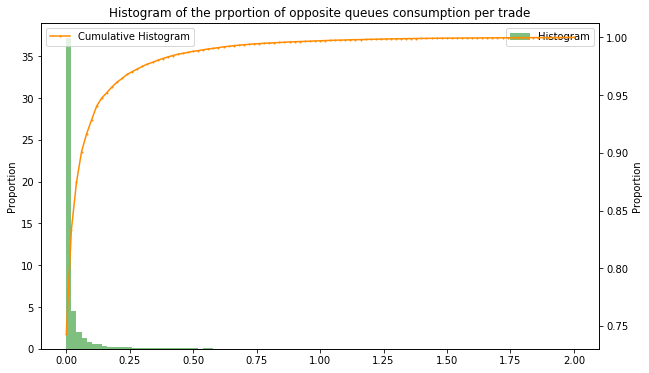

In [30]:
hist(dfSPMINI['quotient_trades_best_opposed_WN'][dfSPMINI['quotient_trades_best_opposed_WN'] < 2], 100, 'Histogram of the prportion of opposite queues consumption per trade', 'labels')
hist(dfUST['quotient_trades_best_opposed_WN'][dfUST['quotient_trades_best_opposed_WN'] < 2], 100, 'Histogram of the prportion of opposite queues consumption per trade', 'labels')

$\underline{\text{Price changing trades analysis:}}$

In [49]:
acf_price_changing_trades_SPMINI = inter.autocovariance(dfSPMINI[dfSPMINI['order_type'] == 1]['qty_signed'], max_lag)
acf_price_changing_trades_UST = inter.autocovariance(dfUST[dfUST['order_type'] == 1]['qty_signed'], max_lag)

% store acf_price_changing_trades_SPMINI
% store acf_price_changing_trades_UST

# curve fitting 
params1, cov = curve_fit(curve_fittingExpo, np.arange(1,max_lag+1), acf_price_changing_trades_SPMINI[1:] )
appro1 = curve_fittingExpo(np.arange(1,N_SPMINI+1), *params1)

params2, cov = curve_fit(curve_fittingExpo, np.arange(1,max_lag+1), acf_price_changing_trades_UST[1:] )
appro2 = curve_fittingExpo(np.arange(1,N_UST+1), *params2)


Stored 'acf_price_changing_trades_SPMINI' (Series)
Stored 'acf_price_changing_trades_UST' (Series)


/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """


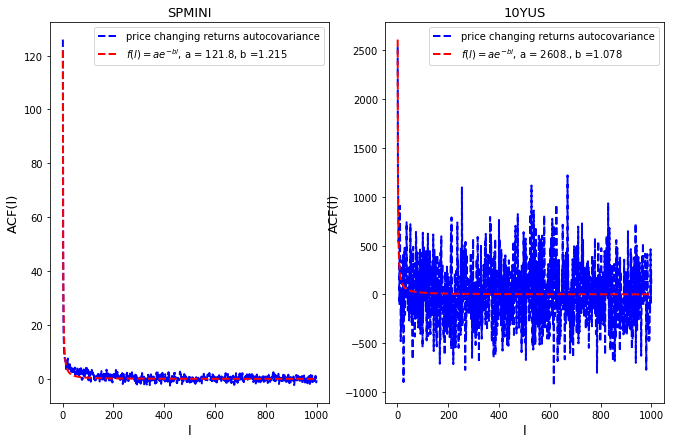

In [50]:
# plot
fig, (ax1) = plt.subplots(1, 2, figsize=[11, 7])

ax1[0].plot(np.arange(1,max_lag+1), acf_price_changing_trades_SPMINI[1:], '--b', linewidth=2, label ='price changing returns autocovariance')
ax1[0].plot(np.arange(1,max_lag+1), appro1[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = ae^{-bl}$' + ', a = ' + str(params1[0])[:5] + ', b =' + str(params1[1])[:5] )
ax1[0].set_xlabel('l', fontsize=13)
ax1[0].set_title('SPMINI', fontsize=13)
ax1[0].set_ylabel('ACF(l)', fontsize=13)
ax1[0].legend()



ax1[1].plot(np.arange(1,max_lag+1), acf_price_changing_trades_UST[1:], '--b', linewidth=2, label ='price changing returns autocovariance')
ax1[1].plot(np.arange(1,max_lag+1), appro2[:max_lag], '--r', linewidth=2, 
label = r'$f(l) = ae^{-bl}$' + ', a = ' + str(params2[0])[:5] + ', b =' + str(params2[1])[:5] )
ax1[1].set_xlabel('l', fontsize=13)
ax1[1].set_title('10YUS', fontsize=13)
ax1[1].set_ylabel('ACF(l)', fontsize=13)
ax1[1].legend()

plt.show()